# Parrot Data Exploration

This is data from a single-threaded run of the first 5ms of our 6 spec benchmarks.

In [735]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pathlib
import matplotlib
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
import statistics
from sortedcontainers import SortedList, SortedDict
import time
from scipy import stats
import pprint

In [736]:
# Globals you may change
DATA_DIR = 'parrot-traces-big/'

In [737]:
# Globals that you should not touch
FILES = [p.absolute() for p in pathlib.Path(DATA_DIR).iterdir()]

In [738]:
def getData(path):
    return pd.read_csv(path, delim_whitespace=True)

def getName(path):
    return path.stem.split('_')[2]

def allData():
    return pd.concat([getData(path).assign(benchmark=getName(path)) for path in FILES])

def iterData():
    for f in FILES:
        yield {'name':getName(f), 'data':getData(f)}

In [ ]:
# Another global you shouldn't touch
MAX_PHASE = max(allData()['phase'])

In [ ]:
for data in iterData():
    print(data['name'])

# Latency Plots

Stack plots, plot a point for each latency, color by phase

In [719]:
def plot1(ax, data):
    #norm = matplotlib.colors.Normalize(vmin=-1,vmax=MAX_PHASE)
    #norm_phase = [norm(p) for p in data['data']['phase']]
    #phase_vals = range(-1,MAX_PHASE+1)
    #cmap, norm = matplotlib.colors.from_levels_and_colors(phase_vals, plt.cm.viridis(phase_vals), extend='min')
    #cmap, norm = matplotlib.colors.from_levels_and_colors(*range(-1,MAX_PHASE), ['red', 'green', 'blue'])
    norm  = matplotlib.colors.Normalize(vmin=-1, vmax=MAX_PHASE, clip=True)
    ax.plot(data['data']['latency_nano'], color=viridis(norm(data['data']['phase'])))#, cmap=cmap, norm=norm)
    
def plot2(ax, data):
    colormap = plt.cm.viridis #or any other colormap
    normalize = matplotlib.colors.Normalize(vmin=-1, vmax=15)
    ax.scatter([*range(0,len(data['data']['latency_nano']))], data['data']['latency_nano'], c=data['data']['phase'], s=5, cmap=colormap, norm=normalize)
    
#fig, axs = plt.subplots(nrows=len(FILES), sharex=True, sharey=True)
#for ax, data in zip(axs, iterData()):
#    data['data'] = data['data'].sample(frac=.1)
#    plot2(ax, data)

#fig.set_size_inches((10,5))
#plt.show()

# Empirical Distribution Function

Let's look at the ECDF of each phase for each benchmark.

In [730]:
def subsetPhase(df, phase_id):
    return df[df['phase'] == phase_id]

def goTufte(ax):
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

def plot4(ax, data):
    ax.plot(sorted(data['latency_nano']))
    goTufte(ax)
    
def plot_unsorted(ax, data):
    ax.plot(data['latency_nano'])
    goTufte(ax)
    
def plot3(ax, data):
    ecdf = ECDF(data['latency_nano'])
    ax.plot(ecdf.x, ecdf.y)
    goTufte(ax)
    
def plot_inverse_cdf(ax, data):
    ecdf = ECDF(data['latency_nano'])
    
    slope_changes = sorted(set(data['latency_nano']))
    
    sample_edf_values_at_slope_changes = [ ecdf(item) for item in slope_changes]
    inverted_edf = interp1d(sample_edf_values_at_slope_changes, slope_changes)
    x = np.linspace(0.5, 1)
    y = inverted_edf(x)
    
    ax.plot(x,y)
    goTufte(ax)


def plotRow(axs, data, rowmax, plotter):
    df = data['data']
    name = data['name']
    axs[0].set_ylabel(name, rotation=0, labelpad=10, ha='right')
    plotter(axs[0], df)
    nphase = max(df['phase'])
    for i in range(nphase+1):
        plotter(axs[i+1], subsetPhase(df, i))
    for i in range(nphase+2,rowmax):
        goTufte(axs[i])


def latencyPerPhase(plotter, title):
    fig, axs = plt.subplots(nrows=len(FILES), ncols=MAX_PHASE+2, sharey=True)
    for i,data in enumerate(iterData()):
        
        plotRow(axs[i], data, MAX_PHASE+2, plotter)
        axs[i][0].set_facecolor('#ebebeb')
        
        if i == len(FILES)-1:
            axs[i][0].set_xlabel('All')
            axs[i][1].set_xlabel('Phase 0')
            for j in range(2,MAX_PHASE+2):
                axs[i][j].set_xlabel(j-1)
                
    fig.set_size_inches((MAX_PHASE*3, nrows))
    plt.suptitle(title)
    plt.minorticks_off()
    plt.show()

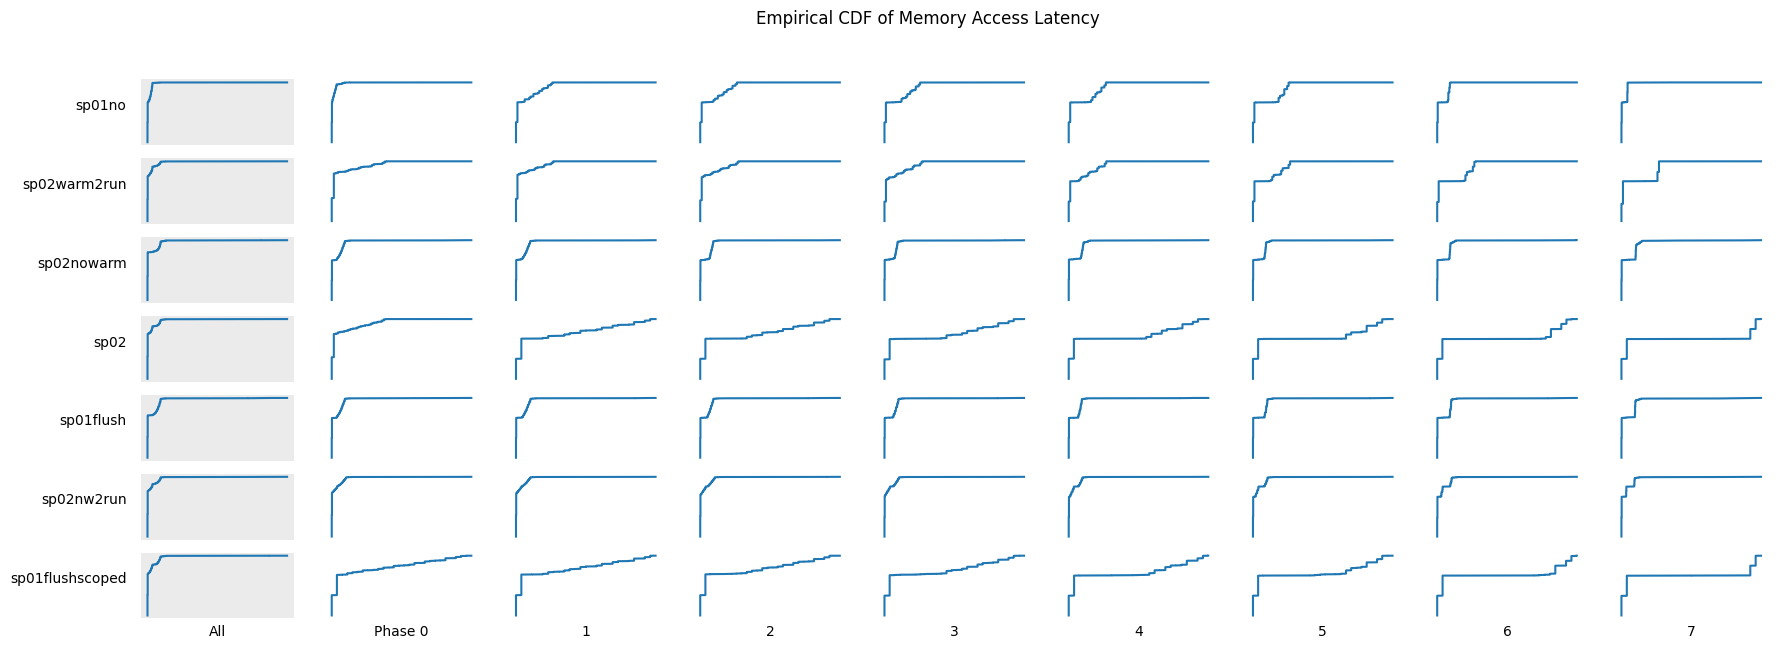

In [731]:
latencyPerPhase(plot3, 'Empirical CDF of Memory Access Latency')

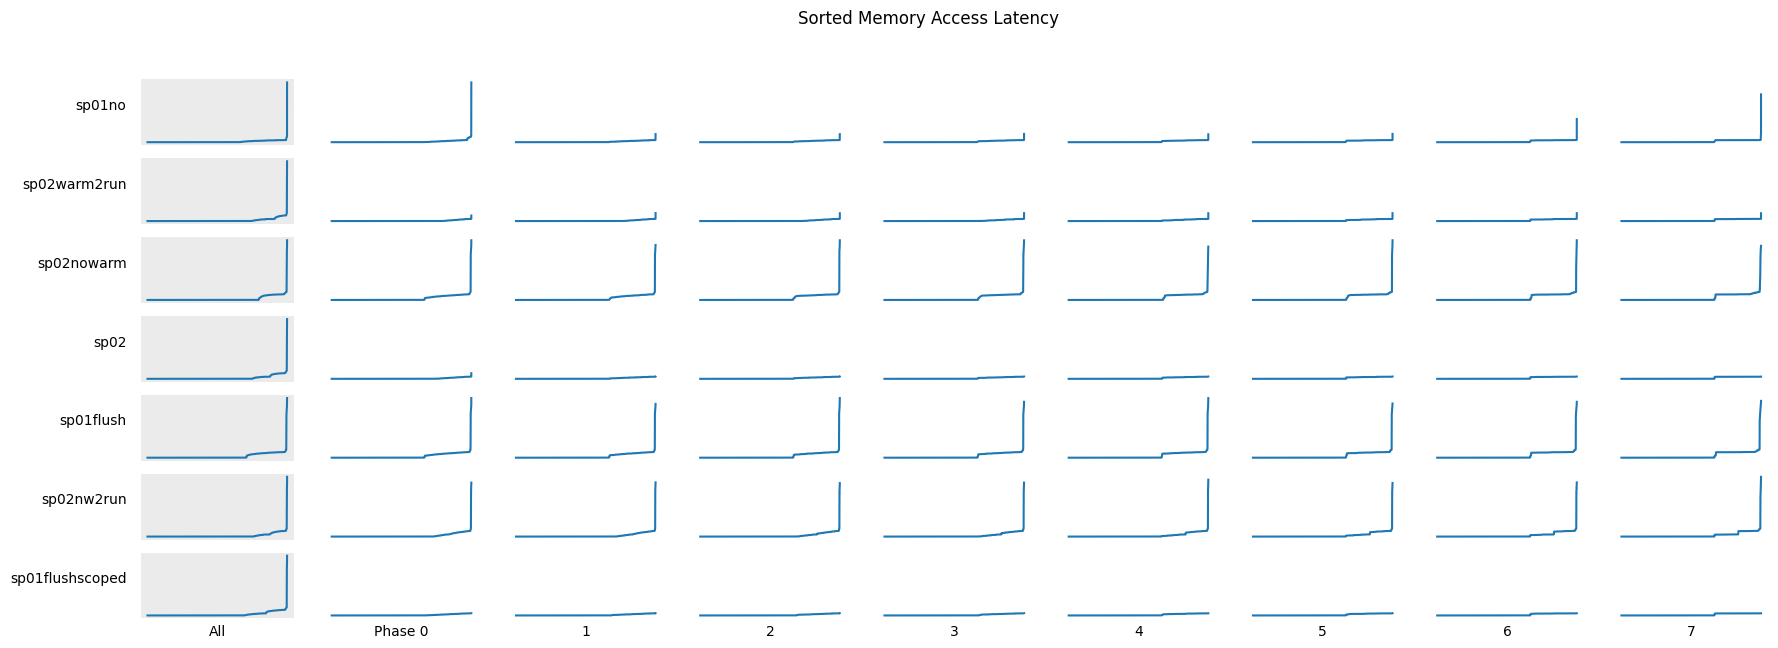

In [732]:
latencyPerPhase(plot4, 'Sorted Memory Access Latency')

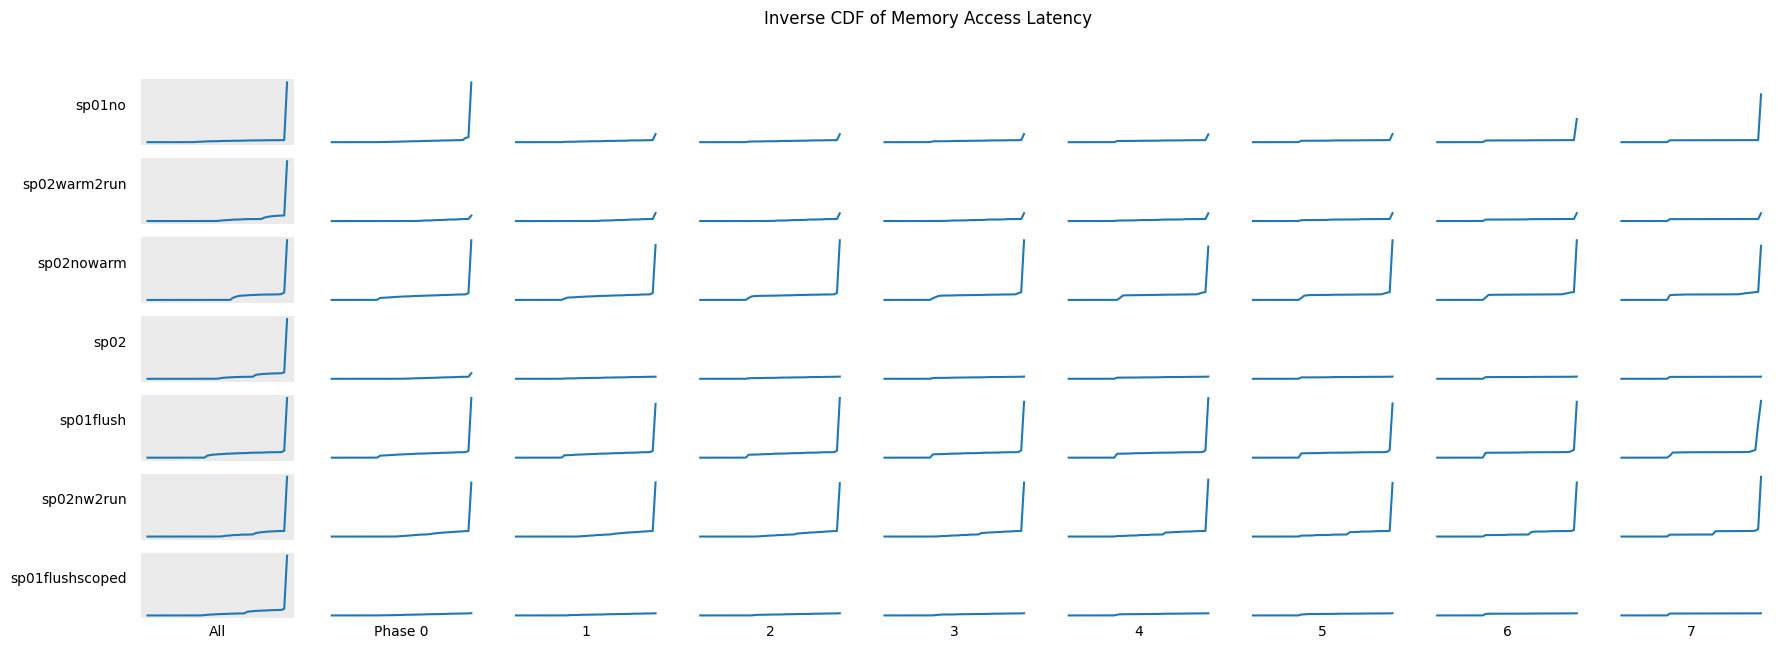

In [733]:
latencyPerPhase(plot_inverse_cdf, 'Inverse CDF of Memory Access Latency')

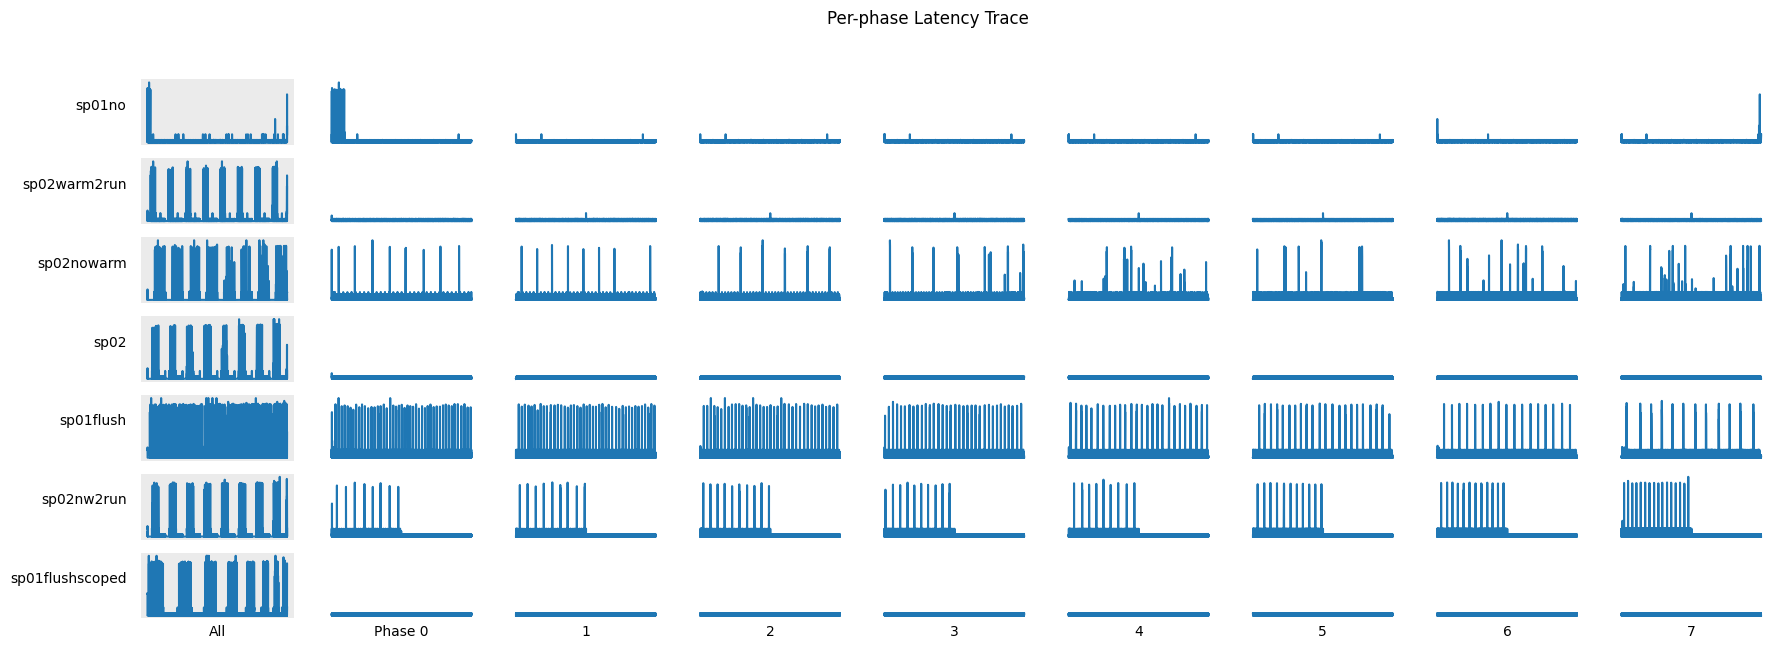

In [734]:
latencyPerPhase(plot_unsorted, 'Per-phase Latency Trace')

In [725]:
pp = pprint.PrettyPrinter(indent=4).pprint

def _mode(data):
    return stats.mode(data,keepdims=False).mode
def _mean(data):
    return np.mean(data)
def _sd(data):
    return np.std(data)
def _len(data):
    return len(data)

def summarize_dataset(data, fn):
    ret = []
    df = data['data']
    
    nphase = max(df['phase'])
    for i in range(nphase+1):
        ret.append(fn(np.array(subsetPhase(df,i)['latency_nano'])))
    return ret

def summarize_all(fn):
    ret = {}
    for data in iterData():
        ret[data['name']] = summarize_dataset(data, fn)

    return ret



#print(summarize_all(_mode))
print('mean')
pp(summarize_all(_mean))
print('sd')
pp(summarize_all(_sd))
#print(summarize_all(_len))

mean
{   'sp01flush': [   21.639684996045258,
                     21.961930057547587,
                     23.037563358215834,
                     24.014374896414562,
                     25.125279271824574,
                     26.07978498963474,
                     27.499561667853815,
                     29.582027450556577],
    'sp01flushscoped': [   6.833153385103055,
                           7.214702533447196,
                           7.518008425749237,
                           8.107658648161857,
                           8.930812317201038,
                           9.320897713509744,
                           10.014773599386032,
                           10.485919680017297],
    'sp01no': [   8.409241411968686,
                  7.440846556906593,
                  7.941668696751975,
                  8.468506785521555,
                  9.023188651365379,
                  9.538698420573885,
                  10.08001022997777,
                  10.614856100907947]

In [726]:
CUTOFF = 2000
FRAC = .75

def maxPhase(df):
    return max(df['phase'])


def reuse_distance(ad):
    times = SortedDict()
    addrs = SortedDict()
    reuse = []
    for time, a in enumerate(ad.flatten()): # O(N)
        if a not in addrs: 
            times[time] = a # O(log(M))
            addrs[a] = time # O(log(M))
        else:
            idx = times.index(addrs[a]) # time of last access
            reuse.append(len(times) - idx - 1)
        
            addrs[a] = time
            deb = times.popitem(idx)
            times[time] = a
    if len(reuse) == 0:
        return np.nan
    return reuse

def approx_reuse_distance(ad):
    times = SortedDict()
    addrs = SortedDict()
    reuse = []
    for time, a in enumerate(ad.flatten()): # O(N)
        if a not in addrs: 
            times[time] = a # O(log(M))
            addrs[a] = time # O(log(M))
        else:
            idx = times.index(addrs[a]) # time of last access
            reuse.append(len(times) - idx - 1)
        
            addrs[a] = time
            deb = times.popitem(idx)
            times[time] = a
        if len(times) > CUTOFF:
            times_removed = [times.popitem(0) for i in range(int(FRAC*CUTOFF))]
            [addrs.pop(times_removed[i][1]) for i in range(int(FRAC*CUTOFF))]
                       
    if len(reuse) == 0:
        return np.nan
    return reuse

class RDInfo():
    def __init__(self, dd, rd_algo):
        self.name = dd['name']
        self.maxp = maxPhase(dd['data'])
        self.overall_rd = rd_algo(np.array(dd["data"].loc[:,"addr"]))
        self.phase_rd = []
        start = time.time()
        for p in range(self.maxp+1):
            addr = np.array(dd['data'].loc[dd['data']['phase']==p, ['addr']])
            self.phase_rd.append(rd_algo(addr))
        self.time = time.time() - start

    def __repr__(self):
        s = ''
        s += f'{self.name}: [{np.mean(self.overall_rd):.2f}] [ '
        for i in range(self.maxp+1):
            s += f'{np.mean(self.phase_rd[i]):.2f} '
        s += f'] ({self.time:.2f}s)'
        return s



In [727]:
real_rd = {}
approx_rd = {}

st = time.time()
for dd in iterData():
    real_rd[dd['name']] = RDInfo(dd, reuse_distance)
    #approx_rd[dd['name']] = RDInfo(dd, approx_reuse_distance)
    
print(f'Total time: {time.time() - st:.2f}s')



Total time: 40.60s


In [728]:
#def percent_difference(old, new):
#    return np.abs(100 * (new - old) / old)
#
#for name in real_rd:
#    real = real_rd[name]
#    approx = approx_rd[name]
#    
#    print(f'{name}: \t{percent_difference(np.mean(real.overall_rd), np.mean(approx.overall_rd)):.2f}%')
#    print(' ', end='')
#    for i in range(len(real.phase_rd)):
#        print(f'{percent_difference(np.mean(real.phase_rd[i]), np.mean(approx.phase_rd[i])):.2f}', end = ' ')
#        
#    print()

    

sp01no
[7020.1126838753235, 7559.115276890502, 7486.724150051748, 7389.021873945149, 7166.187767775195, 6960.95492654286, 6693.649004220798, 6396.171204559467, 6065.214599244243, 5655.835017840056]
[3085.861297452402, 5611.539286776016, 6440.088874718874, 6854.226500877309, 7102.753738654782, 7268.453738011736, 7386.900485808878, 7475.567097888484, 7544.610273356829, 7600.764545532097]
[2692.0465823831746, 4891.874580001034, 5626.05941139982, 5992.99377480754, 6213.154044969044, 6360.240328071423, 6465.078280537258, 6543.66760081304, 6604.792622009255, 6654.528286532494]
[2314.1653100208227, 4202.21858059853, 4831.963723347502, 5146.8925601345745, 5335.866761201324, 5461.7455249458635, 5551.824173662926, 5619.199331431742, 5671.8109804716405, 5714.443751688628]
[1935.0410636982065, 3511.4026447882416, 4037.243176758376, 4300.262324651364, 4458.056375307665, 4563.25203391694, 4638.360507577141, 4694.562518520427, 4738.414325829829, 4774.235257376207]
[1558.2113135778354, 2821.4107608681

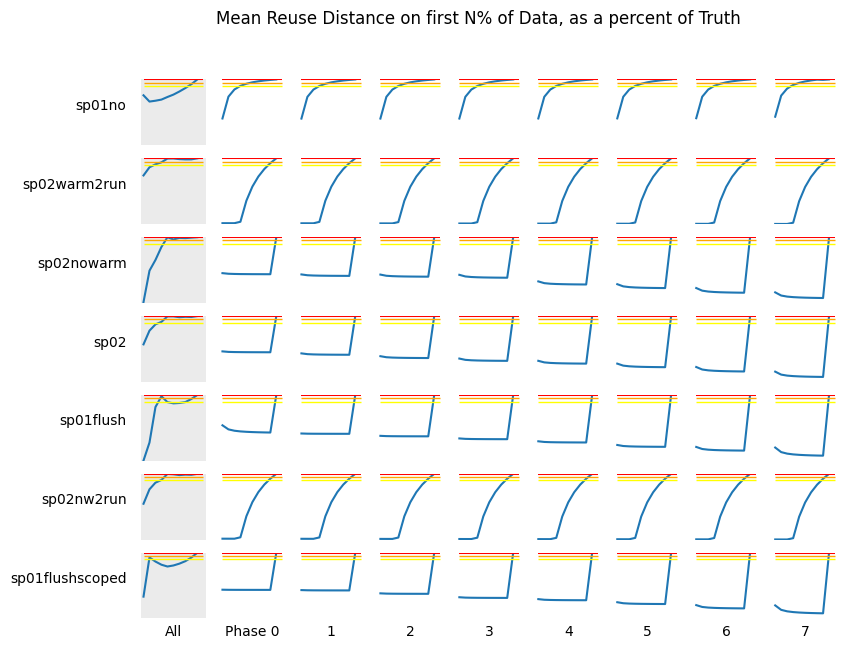

In [729]:
# Let's look at how well we approximate the MRUD by only using the first n*.10 of the trace from n = 1 to 10

#for name in real_rd:
#    print(name)
N=10
def rud_vals(rd):
    return [np.mean(rd[:int(((i+1)/N)*len(rd))]) for i in range(N)]

def frac_difference(old, new):
    return np.abs((new - old) / old)

def pct_change_from_last(v):
    v_last = v[-1]
    return [1-frac_difference(v[-1], v[i]) for i in range(len(v))]

def rud_plot(ax, rd):
    if rd is np.nan:
        return
    vals_uncorrected = rud_vals(rd)
    print(vals_uncorrected)
    vals = pct_change_from_last(vals_uncorrected)
    ax.plot(vals)
    ax.hlines(y=vals[-1], xmin=0, xmax=len(vals), color='red')
    ax.hlines(y=0.95, xmin=0, xmax=len(vals), color='orange', linewidth=1)
    ax.hlines(y=0.90, xmin=0, xmax=len(vals), color='yellow', linewidth=1)
    goTufte(ax)

def rud_plot_row(ax, rdi, name):
    rud_plot(ax[0], rdi.overall_rd)
    for i in range(len(rdi.phase_rd)):
        rud_plot(ax[i+1], rdi.phase_rd[i])
        
    # Style stuff
    ax[0].set_ylabel(name, rotation=0, labelpad=10, ha='right')
    ax[0].set_facecolor('#ebebeb')
    [goTufte(axi) for axi in ax]
    [axi.set_ylim(0,1) for axi in ax]

nrows = len(real_rd)
ncols = MAX_PHASE+2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
for i, name in enumerate(real_rd):
    print(name)
    rud_plot_row(ax[i], real_rd[name], name)
    
    # Style stuff
    if i == len(real_rd)-1:
        ax[i][0].set_xlabel('All')
        ax[i][1].set_xlabel('Phase 0')
        for j in range(2,MAX_PHASE+2):
            ax[i][j].set_xlabel(j-1)
    
fig.set_size_inches((ncols, nrows))
fig.suptitle('Mean Reuse Distance on first N% of Data, as a percent of Truth')
plt.show()


# Q: what percent of instructions are in phase vs transition


------------------


reverse engineer phases for spatter using memory access patterns
if we have perfect phases can we predict locality




In [ ]:
def frac_difference(old, new):
    return np.abs((new - old) / old)

def pct_change_from_last(v):
    v_last = v[-1]
    return [1-frac_difference(v[-1], v[i]) for i in range(len(v))]
    
pct_change_from_last(vals)


In [594]:
stats.mode([1, 1, 2, 3], keepdims=False).mode

1

In [615]:
[*range(10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]